In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator
from typing import Callable, Union
from concurrent import futures
from tqdm.notebook import tqdm
from functools import partial

import models


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def get_carbon_production(v: Union[dict[str, float], pd.DataFrame]):
    return (v["PGA_out"] + v["DHAP_out"] + v["GAP_out"]) * 3 + v["starch_production"] * 6


def plot_by_enzyme(m, p, df, name, n_cols=4):
    n_rows = math.ceil(len(parameters_to_scan) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), sharey=True)
    for ax, par in zip(axs.flatten(), p.columns):
        ax.plot(p[par], df[name], "o")
        ax.set(xlabel=par)
        ax.set_xscale("log")
        ax.axvline(m.get_parameter(par), color="grey", linestyle="dashed")
    fig.suptitle(f"Steady-state {name}", size=14)
    fig.tight_layout()
    plt.show()

In [2]:
def get_model():
    m = models.get_c3_mesophyll()
    m.update_parameters(
        {
            "pfd": 700,
            "O2": 0.1,
            "CO2_ext": 2,
            "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
        }
    )
    return m

In [3]:
y0 = {
    "PGA": 2.22873434718272,
    "BPGA": 0.0011395172052077612,
    "GAP": 0.01437795470974676,
    "DHAP": 0.3163149207711214,
    "FBP": 0.03229051286383597,
    "F6P": 1.4343838296513272,
    "G6P": 3.2990828070597114,
    "G1P": 0.19134680278075727,
    "SBP": 0.1335411445953625,
    "S7P": 0.39001212495414045,
    "E4P": 0.03247522204994075,
    "X5P": 0.05334449596937869,
    "R5P": 0.08935202710233939,
    "RUBP": 0.01800248355473164,
    "RU5P": 0.035740810220277044,
    "ATP": 1.5874832946823467,
    "Fd": 1.8290228380069975,
    "H_lumen": 0.0025962760706543775,
    "LHC": 0.6898134477022976,
    "NADPH": 0.676312076692619,
    "PC": 3.5654905892778137,
    "PQ": 7.816317812545427,
    "Psbs": 0.9396093683259324,
    "Vx": 0.8977559186623475,
    "TR_ox": 0.7059742923625622,
    "E_inactive": 1.5227432839282888,
    "MDA": 0.00010516387564148172,
    "H2O2": 5.828488769494365e-05,
    "DHA": 2.7489043868278393e-06,
    "GSSG": 1.3335621272543244e-06,
    "GLY": 11.927538736093107,
    "GLYC": 0.01453827416297996,
    "GLYX": 0.21956585389678646,
    "HPA": 0.003014225861566207,
    "SER": 1.3081512964720516,
    "2PG": 3.7113656305615343e-06,
    "GLYA": 0.004954584293529081,
    "CO2": 1.0061496713328153,
    "HCO3": 50.30748356664077,
}

s = Simulator(get_model())
s.initialise(y0)
t, y = s.simulate(1000)
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP", "CO2"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
    ],
    sharey=False,
    ylabels="Concentration",
    xlabels="Time",
)
plt.show()

**Keq**

| Enzyme                           | Reaction                                                     | Keq    | Source       |
| :------------------------------- | :----------------------------------------------------------- | ------ | ------------ |
| phosphoglycolate phosphatase     | H2O + 2-Phosphoglycolate <=> Orthophosphate + Glycolate      | 3.1e5  | Equilibrator |
| glycolate oxidase                | Oxygen + Glycolate <=> Hydrogen peroxide + Glyoxylate        | 3e15   | Equilibrator |
| glycine transaminase             | L-Glutamate + Glyoxylate <=> 2-Oxoglutarate + Glycine        | 3e1    | Equilibrator |
| glycine decarboxylase            | NAD  + Glycine + Tetrahydrofolate + H2O <=> NADH + NH3 + 5,10-Methylenetetrahydrofolate + CO2(total) | 3.6e-3 | Equilibrator |
| glycine hydroxymethyltransferase | H2O + Glycine + 5,10-Methylenetetrahydrofolate <=> L-Serine + Tetrahydrofolate | 0.07   | Equilibrator |
| serine glyoxylate transaminase   | Glyoxylate + L-Serine <=> Glycine + Hydroxypyruvate          | 6      | Equilibrator |
| glycerate dehydrogenase          | NADH + Hydroxypyruvate <=> NAD  + D-Glycerate                | 8.7e4  | Equilibrator |
| glycerate kinase                 | ATP + D-Glycerate <=> ADP + 3-Phospho-D-glycerate            | 4.9e2  | Equilibrator |
| catalase                         | 2 Hydrogen peroxide <=> 2 H2O + Oxygen                       | 4.3e33 | Equilibrator |
|                                  | Glyoxylate + H2O2 <=> Formate + CO2(total)                   | 7.1e65 | Equilibrator |
|                                  | Hydroxypyruvate + H2O2 <=> Glycolate + CO2(total)            | 3.3e72 | Equilibrator |



**Kcat**

| Enzyme   | Name                                  | Value                    | Unit | Organism             | Database |
| -------- | ------------------------------------- | ------------------------ | ---- | -------------------- | -------- |
| 3.1.3.18 | phosphoglycolate phosphatase          | 292                      | 1/s  | Spinacia oleracea    | Brenda   |
| 1.1.3.15 | glycolate oxidase                     | 1.04 ?                   | 1/s  | Spinacia oleracea    | Brenda   |
| 1.1.3.15 | glycine transaminase                  | 15.6 (glycolate)         | 1/s  | Homo sapiens         | Brenda   |
| 1.4.4.2  | glycine decarboxylase (dehydrogenase) | 0.0001 - 0.047 (glycine) | 1/s  | Homo sapiens         | Brenda   |
| 2.1.2.1  | glycine hydroxymethyltransferase      | 0.1888 (glycine)         | 1/s  | Homo sapiens         | Brenda   |
| 2.6.1.45 | serine glyoxylate transaminase        | 6.4                      | 1/s  | Arabidopsis thaliana | Brenda   |
| 1.1.1.95 | glycerate dehydrogenase               | 1.741 (phosphoglycerate) | 1/s  | Arabidopsis thaliana | Brenda   |
|          | glycerate kinase                      |                          |      |                      |          |
|          | catalase                              |                          |      |                      |          |



In [4]:
m = get_model()
for i in [
    "vmax_phosphoglycolate_phosphatase",
    "vmax_glycolate_oxidase",
    "vmax_glycine_decarboxylase",
    "vmax_ser_gly_transaminase",
    "vmax_glycerate_dehydrogenase",
]:
    print(f"{i:<35}: {m.parameters[i]}")

vmax_phosphoglycolate_phosphatase  : 292
vmax_glycolate_oxidase             : 0.19157088122605365
vmax_glycine_decarboxylase         : 0.19157088122605365
vmax_ser_gly_transaminase          : 0.3045977011494253
vmax_glycerate_dehydrogenase       : 0.7624521072796936


In [5]:
from models.shared_rate_functions import (
    reversible_michaelis_menten_1s_1p,
    reversible_michaelis_menten_2s_2p,
)

m = get_model()

m.update_parameters(
    {
        "pfd": 700,
        "O2": 0.1,
        "CO2_ext": 2,
        "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
        "vmax_glycolate_oxidase": 1,
        "vmax_glycine_decarboxylase": 1,
        "vmax_ser_gly_transaminase": 6.4,
        "vmax_glycerate_dehydrogenase": 1.741,
    }
)

m.add_parameters(
    {
        "keq_glycine_transaminase": 3e1,
        "keq_serine_glyoxylate_transaminase": 6,
        # Influx and outflux
        "keq_glycerate_dehydrogenase": 8.7e4,
        "keq_phosphoglycolate_phosphatase": 3.1e5,
        "kmp_glycerate_dehydrogenase": 1,
        "kmp_phosphoglycolate_phosphatase": 1,
        "kmp_glycine_transaminase": 1,
        "kmp_transaminase_serine": 1,
    }
)

m.update_reaction(
    rate_name="glycerate_dehydrogenase",
    function=reversible_michaelis_menten_1s_1p,
    parameters=[
        "vmax_glycerate_dehydrogenase",
        "kms_glycerate_dehydrogenase",
        "kmp_glycerate_dehydrogenase",
        "keq_glycerate_dehydrogenase",
    ],
    reversible=True,
)

m.update_reaction(
    rate_name="phosphoglycolate_phosphatase",
    function=reversible_michaelis_menten_1s_1p,
    parameters=[
        "vmax_phosphoglycolate_phosphatase",
        "kms_phosphoglycolate_phosphatase",
        "kmp_phosphoglycolate_phosphatase",
        "keq_phosphoglycolate_phosphatase",
    ],
    reversible=True,
)

# m.update_reaction(
#     rate_name="glycine_decarboxylase",
#     function=reversible_michaelis_menten_1s_3p,
#     parameters=[
#         "vmax_glycine_decarboxylase",
#         "km_glycine_decarboxylase",
#         "keq_glycine_decarboxylase",
#     ],
#     reversible=True,
# )
m.update_reaction(
    rate_name="glycine_transaminase",
    function=reversible_michaelis_menten_1s_1p,
    parameters=[
        "vmax_glycine_transaminase",
        "kms_glycine_transaminase",
        "kmp_glycine_transaminase",
        "keq_glycine_transaminase",
    ],
    reversible=True,
)
m.update_reaction(
    rate_name="serine_glyoxylate_transaminase",
    function=reversible_michaelis_menten_2s_2p,
    parameters=[
        "vmax_ser_gly_transaminase",
        # "km_transaminase_glyxoylate",
        "kms_transaminase_serine",  # the larger one
        "kmp_transaminase_serine",  # the larger one
        "keq_serine_glyoxylate_transaminase",
    ],
    reversible=True,
)

In [6]:
s = Simulator(m)
s.update_parameters(
    {
        "CO2_ext": 1,
        "O2": 0.25,
    }
)
s.initialise(y0)
t, y = s.simulate(100_000)
c = s.get_full_results_df()
v = s.get_fluxes_df()

(<Figure size 1080x288 with 3 Axes>,
 array([[<AxesSubplot:xlabel='Time', ylabel='Concentration'>,
         <AxesSubplot:xlabel='Time', ylabel='Concentration'>,
         <AxesSubplot:xlabel='Time', ylabel='Concentration'>]],
       dtype=object))

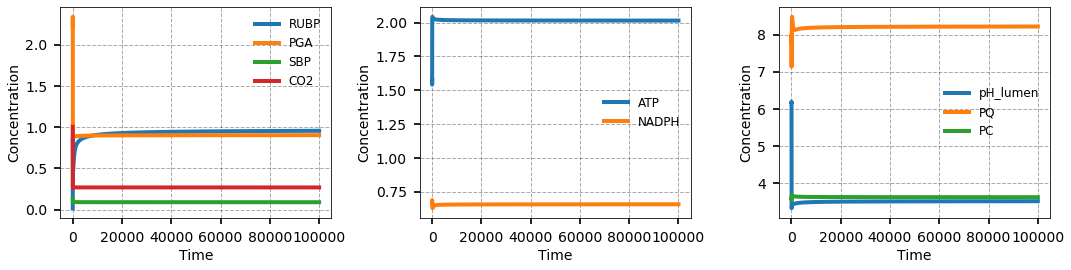

In [7]:
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP", "CO2"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
    ],
    sharey=False,
    ylabels="Concentration",
    xlabels="Time",
)

## Steady light, varying CO2 and O2

In [8]:
from tqdm.auto import tqdm

In [9]:
# s = Simulator(get_model())
s = Simulator(m)
s.update_parameter("pfd", 700)
s.initialise(y0)

cs, vs = s.parameter_scan_2d_with_fluxes(
    p1=("CO2_ext", np.linspace(0, 2, 10)),
    p2=("O2", np.linspace(0, 0.25, 10)),
)

O2:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/10 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/marvin/git/modelbase-software/modelbase/ode/simulators/abstract_simulator.py", line 704, in _scan_multiprocessing
    for task in futures.as_completed((executor.submit(worker, i) for i in parameter_values)):
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/concurrent/futures/_base.py", line 245, in as_completed
    waiter.event.wait(wait_timeout)
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/threading.py", line 574, in wait
    signaled = self._cond.wait(timeout)
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()


Process ForkProcess-19:


KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-1ef0d1b44ac2>", line 6, in <module>
    cs, vs = s.parameter_scan_2d_with_fluxes(
  File "/home/marvin/git/modelbase-software/modelbase/ode/simulators/abstract_simulator.py", line 824, in parameter_scan_2d_with_fluxes
    c, v = self.parameter_scan_with_fluxes(
  File "/home/marvin/git/modelbase-software/modelbase/ode/simulators/abstract_simulator.py", line 777, in parameter_scan_with_fluxes
    results = self._scan_multiprocessing(parameter_name, parameter_values, worker)
  File "/home/marvin/git/modelbase-software/modelbase/ode/simulators/abstract_simulator.py", line 706, in _scan_multiprocessing
    pbar.update(1)
  File "/home/marvin/miniconda3/envs/mb39/lib

Traceback (most recent call last):


  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/threading.py", line 1033, in join
    self._wait_for_tstate_lock()
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/marvin/miniconda3/envs/mb39/lib/python3

  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)


TypeError: object of type 'NoneType' has no len()

  File "/home/marvin/miniconda3/envs/mb39/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
rubisco_co2 = np.array([v["rubisco_co2"].values for v in vs.values()])
rubisco_o2 = np.array([v["rubisco_o2"].values for v in vs.values()])
ph = np.array([c["pH_lumen"].values for c in cs.values()])

In [ ]:
rubisco_co2[np.isnan(rubisco_co2)] = 0
rubisco_o2[np.isnan(rubisco_o2)] = 0

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    *np.meshgrid(np.linspace(0, 2, 10), np.linspace(0, 0.25, 10)),
    rubisco_co2,
    cmap="RdYlBu_r",
    edgecolor="none",
)

In [ ]:
%matplotlib notebook

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    *np.meshgrid(np.linspace(0, 2, 10), np.linspace(0, 0.25, 10)),
    rubisco_o2,
    cmap="RdYlBu_r",
    edgecolor="none",
)

In [ ]:
%matplotlib inline

## Steady light, vary only one

In [ ]:
s = Simulator(get_model())
s.update_parameter("CO2_ext", 1)
s.initialise(y0)
c, v = s.parameter_scan_with_fluxes("O2", np.linspace(0, 0.25, 20), tolerance=1e-4)

In [ ]:
s = Simulator(get_model())
s.update_parameter("CO2_ext", 1)
s.update_parameter("O2", 0.250000)
s.initialise(y0)
t, y = s.simulate(100_000)

In [ ]:
c = s.get_full_results_df()
v = s.get_fluxes_df()

In [ ]:
diffs = (v.iloc[-1] - v.iloc[-2]).abs().sort_values(ascending=False)
diffs

In [ ]:
v.loc[:, diffs[:5].index].plot()

In [ ]:
diffs = (c.iloc[-1] - c.iloc[-2]).abs().sort_values(ascending=False)
diffs

In [ ]:
c.loc[:, diffs[1:5].index].plot()

## Steady-state behaviour under continuous light

In [ ]:
s = Simulator(get_model())
s.update_parameter("O2", 0.2)
s.initialise(y0)
c, v = s.parameter_scan_with_fluxes("pfd", np.linspace(0, 1400))

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

v["vPS1"].plot(ax=ax1, label="rate through PS1")
(v["vPS2"] * 2).plot(ax=ax1, label="LEF")
(v["vCyc"] * 2).plot(ax=ax1, label="CEF")

ax2.plot(v["vMehler"], "r--", label="Mehler")
ax2.plot(v["vPTOX"], "r.", label="PTOX")


ax1.set(
    title="photosynthetic electron fluxes",
    xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
    ylabel="mmol e$^-$/mol Chl/s",
)
ax1.legend(loc="upper left", borderaxespad=0.5)
ax2.set_xlabel("PPFD")
ax2.set_ylabel("mmol e$^-$/mol Chl/s", color="red"),
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="lower right", borderaxespad=0.5)

## Metabolic control analysis

## ROS production